In [1]:
## read the data
import scipy.io
data = scipy.io.loadmat('/Users/jinyanwei/Desktop/BP_Model/Data/Cuffless_BP_Estimation/part_1.mat')

In [4]:
fs =125 # Sample rate in Hz
bp_standard_rate = 200

import numpy as np
def straighten_ecg(ecg_signal):
    detrended_ecg = np.subtract(ecg_signal, np.mean(ecg_signal))
    return detrended_ecg
    
import numpy as np
def normalize_sinal(ppg):
# Assuming ppg_signal and ecg_signal are your original PPG and ECG signals
    ppg_min = np.min(ppg)
    ppg_max = np.max(ppg)
    normalized_ppg = (ppg - ppg_min) / (ppg_max - ppg_min)
    return normalized_ppg
def standard_signal(bp): 
    return (bp - np.mean(bp)) / np.std(bp)
def inverse_standard_signal(bp_ori, bp_est):
    mean = np.mean(bp_ori)
    std = np.std(bp_ori)
    return (bp_est * std) + mean

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
def align_ppgbp_segment(ppg_signal, bp_signal1, bp_signal2, ecg_signal, show=0): ## ppg_signal = ppg_normalized, bp_signal = bp_normalized, ecg_signal = ecg_normalized; get ppg_aligned, bp_aligned
    ppg_peaks, _ = find_peaks(ppg_signal, height=0.5)  # Adjust the height threshold as needed
    bp_peaks, _ = find_peaks(bp_signal1, height=0.4)
    ecg_peaks, _ = find_peaks(ecg_signal, height=0.65)
    #print(f'ppg peaks: {len(ppg_peaks)} {ppg_peaks}')
    #print(f'ecg peaks: {len(ecg_peaks)} {ecg_peaks}')

    first_ecg_peak = ecg_peaks[0]
    #print(f'first ecg peak: {first_ecg_peak}')
    indices_ppg = np.argwhere(ppg_peaks[:10] > first_ecg_peak)
    first_ppg_peak = ppg_peaks[int(indices_ppg[0])]
    #print(f'first ppg peak: {first_ppg_peak}')
    indices_bp = np.argwhere(bp_peaks[:10] > first_ecg_peak)
    first_bp_peak = bp_peaks[int(indices_bp[0])]
    #print(f'first bp peak: {first_bp_peak}')
    ppg_bp_peaks_subtraction = abs(bp_peaks[int(indices_bp[0]):int(indices_bp[0])+20] - ppg_peaks[int(indices_ppg[0]):int(indices_ppg[0])+20])
    #print(ppg_bp_peaks_subtraction)
    distance_ppgbp = np.bincount(ppg_bp_peaks_subtraction).argmax()
    #print(move_distance)
    #print(bp_peaks[int(indices_bp[0]):int(indices_bp[0])+20] - ppg_peaks[int(indices_ppg[0]):int(indices_ppg[0])+20])
    #print(f'distance:{distance_ppgbp}')
    if first_bp_peak > first_ppg_peak:
        bp_aligned = bp_signal1[distance_ppgbp:]
        bp_ori_aligned = bp_signal2[distance_ppgbp:]
        ppg_aligned = ppg_signal
    elif first_bp_peak < first_ppg_peak:
        bp_aligned = bp_signal1
        bp_ori_aligned = bp_signal2
        ppg_aligned = ppg_signal[distance_ppgbp:]
    else:
        bp_aligned = bp_signal1
        bp_ori_aligned = bp_signal2
        ppg_aligned = ppg_signal
    #print(f'ppg len: {len(ppg_aligned)}')
    #print(f'bp len: {len(bp_aligned)}')
    min_len = min(len(bp_aligned), len(ppg_aligned))
    ppg_aligned = ppg_aligned[:min_len]
    bp_aligned = bp_aligned[:min_len]
    bp_ori_aligned = bp_ori_aligned[:min_len]
    ecg_aligned = ecg_signal[:min_len]
    #print(ecg_aligned)
    ppg_segmented = ppg_aligned[:first_ecg_peak-5]
    bp_segmented = bp_aligned[:first_ecg_peak-5]
    bp_ori_segmented = bp_ori_aligned[:first_ecg_peak-5]
    ecg_segmented = ecg_aligned[:first_ecg_peak-5]

    for ecgi in range(len(ecg_peaks)-1):
        one_ppg_peak, _ = find_peaks(ppg_aligned[ecg_peaks[ecgi]-5:ecg_peaks[ecgi + 1]-5], height=0.5)
        #print(ecg_peaks[ecgi], one_ppg_peak)
        if len(one_ppg_peak) == 1:
            ppg_segmented = np.concatenate((ppg_segmented, ppg_aligned[ecg_peaks[ecgi]-5:ecg_peaks[ecgi + 1]-5]))
            bp_segmented = np.concatenate((bp_segmented, bp_aligned[ecg_peaks[ecgi]-5:ecg_peaks[ecgi + 1]-5]))
            bp_ori_segmented = np.concatenate((bp_ori_segmented, bp_ori_aligned[ecg_peaks[ecgi]-5:ecg_peaks[ecgi + 1]-5]))
            ecg_segmented = np.concatenate((ecg_segmented, ecg_aligned[ecg_peaks[ecgi]-5:ecg_peaks[ecgi + 1]-5]))

    if show == 1:
        plt.figure(figsize=(30, 6))
        plt.plot(ppg_signal, label='PPG')
        plt.plot(bp_signal1, label='BP')
        plt.plot(ecg_signal, label='ECG')
        plt.scatter(ppg_peaks, ppg_signal[ppg_peaks], color='c', marker='o', label='Aligned PPG Peaks')
        plt.scatter(bp_peaks, bp_signal1[bp_peaks], color='orange', marker='o', label='Aligned BP Peaks')
        plt.scatter(ecg_peaks, ecg_signal[ecg_peaks], color='green', marker='o', label='Aligned BP Peaks')
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.show()

        plt.figure(figsize=(30, 6))
        plt.plot(ppg_segmented, label='PPG')
        plt.plot(bp_segmented, label='BP')
        plt.plot(ecg_segmented, label='ECG')
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.show()

    return ppg_segmented, bp_segmented, bp_ori_segmented, ecg_segmented

import numpy as np
def get_feautres(ppg_signal, bp_signal1, bp_signal2, ecg_signal):
    ori_ecg_peaks, _ = find_peaks(ecg_signal)
    r_peaks = np.array([ecg_peak for ecg_peak in ori_ecg_peaks if ecg_signal[ecg_peak] > 0.65])
    #print(f'r_peaks: {len(r_peaks)} {r_peaks}')
    r_peak_amplitudes = (ecg_signal[r_peaks]).tolist()
    r_peak_amplitudes = r_peak_amplitudes[:-1]
    #print(f'r_peak_amplitudes: {len(r_peak_amplitudes)} {r_peak_amplitudes}')
    r_peak_intervals = (np.diff(r_peaks) / fs).tolist()
    #print(f'r_peak_intervals: {len(r_peak_intervals)} {r_peak_intervals}')
    # calculate low peak, s-peak
    low_peak_amplitudes, r_to_low_peak_amplitudes, s_peak_amplitudes= [], [], []
    low_peaks, s_peaks = [], []
    for i in range(len(r_peaks) - 1):
        r_peak = r_peaks[i]
        next_r_peak = r_peaks[i + 1]
        low_peak_amplitude = np.min(ecg_signal[r_peak:next_r_peak])
        r_to_low_peak_amplitude = ecg_signal[r_peak]-low_peak_amplitude
        low_peak_amplitudes.append(low_peak_amplitude)
        r_to_low_peak_amplitudes.append(r_to_low_peak_amplitude)
        low_peak = r_peak + np.argmin(ecg_signal[r_peak:next_r_peak])
        low_peaks.append(low_peak)
        s_peak_amplitude = np.min(ecg_signal[r_peak:low_peak])
        s_peak_amplitudes.append(s_peak_amplitude)
        s_peak = r_peak + np.argmin(ecg_signal[r_peak:low_peak])
        s_peaks.append(s_peak)   
    #print(f'low peaks: {len(low_peaks)} {low_peaks}')  
    #print(f's peaks: {len(s_peaks)} {s_peaks}')  
    # T-Wave Amplitude Calculation
    r_peaks = np.insert(r_peaks, 0, 0) #the first t-peak is before the R-peak
    t_wave_amplitudes, q_wave_amplitudes = [], []
    t_peaks, q_peaks = [], []
    for i in range(len(r_peaks) - 1):
        r_peak = r_peaks[i]
        next_r_peak = r_peaks[i + 1]
        t_wave_amplitude = np.max(ecg_signal[r_peak:next_r_peak])
        t_wave_amplitudes.append(t_wave_amplitude)
        t_peak = r_peak + np.argmax(ecg_signal[r_peak:next_r_peak])
        t_peaks.append(t_peak)
        q_wave_amplitude = np.min(ecg_signal[t_peak:next_r_peak])
        q_wave_amplitudes.append(q_wave_amplitude)
        q_peak = r_peak + np.argmin(ecg_signal[t_peak:next_r_peak])
        q_peaks.append(q_peak)

    t_wave_amplitudes = t_wave_amplitudes[:-1]
    q_wave_amplitudes = q_wave_amplitudes[:-1]
    #print(f't peaks: {len(t_peaks)} {t_peaks}')  
    #print(f'q peaks: {len(q_peaks)} {q_peaks}')  
    
    # QRS interval
    r_peaks = np.array([ecg_peak for ecg_peak in ori_ecg_peaks if ecg_signal[ecg_peak] > 0.65])
    qrs_intervals = []
    for i in range(len(r_peaks)-1):
        qrs_interval = (ecg_signal[s_peaks[i]] - ecg_signal[q_peaks[i]]) / fs
        qrs_intervals.append(abs(qrs_interval))
    #print(f'qrs_intervals: {len(qrs_intervals)} {qrs_intervals}')  

    # get ppg features:
    ppg_pulses, bp_pulses, bp_ori_pulses = [], [], []
    for i in range(len(r_peaks)-1):
        ppg_pulse = ppg_signal[r_peaks[i]:r_peaks[i+1]]
        bp_pulse = bp_signal1[r_peaks[i]:r_peaks[i+1]]
        bp_ori_pulse = bp_signal2[r_peaks[i]:r_peaks[i+1]]
        ppg_pulses.append(ppg_pulse)
        bp_pulses.append(bp_pulse)
        bp_ori_pulses.append(bp_ori_pulse)
    #print(f'bp pulses: {bp_pulses}')
    ppg_pulse_amplitude = [np.max(pulse) - np.min(pulse) for pulse in ppg_pulses]
    ppg_pulse_width = [pulse.shape[0]/fs for pulse in ppg_pulses]
    ppg_high_to_low_interval = [np.argmin(pulse)/fs for pulse in ppg_pulses]
    ppg_slope_change_std = [np.std(np.diff(pulse)) for pulse in ppg_pulses]

    sbp = [np.max(pulse) for pulse in bp_pulses]
    dbp = [np.min(pulse) for pulse in bp_pulses]
    sbp_ori = [np.max(pulse) for pulse in bp_ori_pulses]
    dbp_ori = [np.min(pulse) for pulse in bp_ori_pulses]
    
    return sbp, dbp, sbp_ori, dbp_ori, ppg_pulse_amplitude, ppg_pulse_width, ppg_high_to_low_interval, ppg_slope_change_std, t_wave_amplitudes, q_wave_amplitudes, r_peak_amplitudes, s_peak_amplitudes, low_peak_amplitudes, qrs_intervals, r_to_low_peak_amplitudes, r_peak_intervals

import matplotlib.pyplot as plt
def show_one(signal1):
    fig = plt.figure(figsize=(30,6))
    plt.plot(signal1)
    return plt.show()
def show_two(signal1, signal2):
    fig = plt.figure(figsize=(30,6))
    plt.plot(signal1, label='1')
    plt.plot(signal2, label='2')
    plt.legend()
    return plt.show()
def show_three(signal1, signal2, signal3):
    fig = plt.figure(figsize=(30,6))
    plt.plot(signal1, label='1')
    plt.plot(signal2, label='2')
    plt.plot(signal3, label='3')
    plt.legend()
    return plt.show()

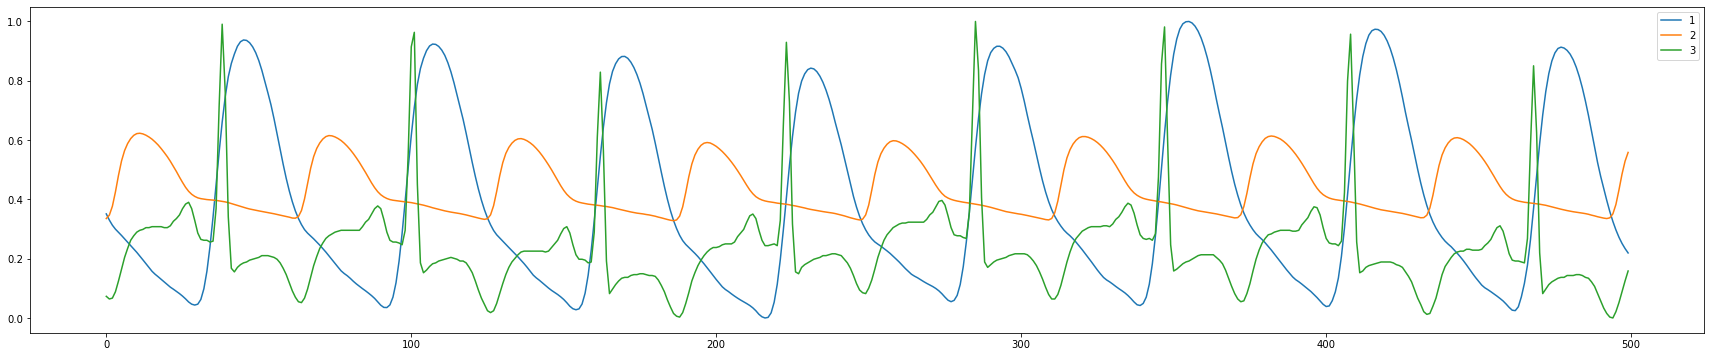

In [30]:
bp_standard_rate = 200
patient_data = data['p'][0,0][:,:500]
ppg_ori = patient_data[0]
bp_ori = patient_data[1]
ecg_ori = patient_data[2]
ecg_detrened = straighten_ecg(ecg_ori)
ppg_normalized = normalize_sinal(ppg_ori)
bp_standarded = bp_ori / bp_standard_rate
ecg_normalized = normalize_sinal(ecg_detrened)
show_three(ppg_normalized, bp_standarded, ecg_normalized)

In [31]:
#def get_ppg_points_index(ppg_signal):
ppg_signal = patient_data[0]
ppg_min_index = []
ppg_max_index = []
for i in range(1, (len(ppg_signal)-1)):
    if (ppg_signal[i] < ppg_signal[i-1]) and (ppg_signal[i] < ppg_signal[i+1]):
        ppg_min_index.append(i)
    if (ppg_signal[i] > ppg_signal[i-1]) and (ppg_signal[i] > ppg_signal[i+1]):
        ppg_max_index.append(i)

ppg_max_slopes_index = []
if ppg_min_index[0] > ppg_max_index[0]:
    ppg_max_index.pop(0)
for i in range(min(len(ppg_min_index), len(ppg_max_index))):  
    ppg_segement = ppg_signal[ppg_min_index[i]:ppg_max_index[i]]
    ppg_slope_list = []
    for point in range(len(ppg_segement)-1):
        ppg_slope_list.append(ppg_segement[point+1]-ppg_segement[point])
    ppg_max_slope = max(ppg_slope_list)
    ppg_max_slope_index_in_segement = ppg_slope_list.index(ppg_max_slope)
    ppg_max_slope_index = ppg_min_index[i] + ppg_max_slope_index_in_segement
    ppg_max_slopes_index.append(ppg_max_slope_index)
print(ppg_max_slopes_index)

[36, 98, 160, 222, 345, 345, 407]


In [20]:
a = [15, 12, 8, 8, 7, 7, 7, 6, 5, 3]
b = [10, 25, 17, 11, 13, 17, 20, 13, 9, 15]
a.pop(0)

15

In [22]:
a = a.pop(0)
a

12

In [ ]:
# get all patient dataset
patients = [0, 1, 2, 3, 4, 6, 14, 15, 16, 18, 24, 35, 36, 37, 39, 40, 41, 46, 64, 66, 67, 73, 79, 80, 81, 82, 86, 87, 88, 89, 93, 94, 95, 98, 99, 100, 101, 102, 103, 104, 105, 108, 109, 110, 111, 115, 116, 117, 118, 120, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 141, 144, 149, 150, 151, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 179, 182, 184, 186, 188, 189, 192, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 206, 207, 208, 209, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 245, 246, 247, 248, 249, 251, 252, 253, 254, 255, 256, 257, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 272, 273, 277, 278, 279, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 295, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 309, 310, 311, 313, 314, 315, 316, 317, 318, 319, 320, 321, 323, 324, 327, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 377, 380, 391, 393, 394, 395, 397, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 413, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 429, 430, 431, 432, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 459, 460, 462, 463, 464, 465, 466, 470, 471, 472, 475, 480, 481, 482, 483, 484, 486, 487, 488, 490, 491, 492, 496, 497, 498, 499, 500, 502, 503, 504, 505, 507, 508, 509, 510, 512, 514, 515, 516, 520, 524, 527, 528, 529, 530, 531, 532, 533, 535, 537, 538, 539, 543, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 564, 565, 570, 576, 577, 578, 582, 590, 592, 593, 597, 599, 600, 602, 603, 604, 606, 607, 609, 612, 625, 626, 627, 628, 629, 630, 633, 634, 635, 639, 640, 641, 644, 646, 648, 653, 655, 656, 657, 658, 662, 670, 673, 674, 676, 677, 681, 682, 683, 685, 686, 687, 688, 689, 692, 693, 695, 696, 697, 698, 700, 703, 704, 705, 706, 707, 708, 709, 711, 712, 717, 719, 720, 721, 722, 723, 724, 725, 727, 729, 730, 731, 733, 734, 735, 736, 737, 741, 743, 744, 748, 749, 753, 754, 755, 756, 759, 774, 775, 776, 777, 780, 781, 783, 784, 785, 786, 787, 790, 791, 792, 794, 799, 800, 801, 802, 803, 805, 807, 808, 809, 810, 813, 820, 821, 822, 823, 828, 829, 830, 843, 845, 847, 868, 869, 922, 923, 947, 948, 949, 951, 952, 957, 959, 960, 962, 972, 975, 981, 989]
sbp500 = []
dbp500 = []
sbp_ori500 = []
dbp_ori500 = []
features500 = []
for patient in patients[:3]:
    patient_data = data['p'][0,patient]
    if len(patient_data[0]) >= 25000:
        ppg_ori = patient_data[0]
        bp_ori = patient_data[1]
        ecg_ori = patient_data[2]
        ecg_detrened = straighten_ecg(ecg_ori)
        ppg_normalized = normalize_sinal(ppg_ori)
        bp_standarded = bp_ori / bp_standard_rate
        ecg_normalized = normalize_sinal(ecg_detrened)
        ppg_segmented, bp_segmented, bp_ori_segmented, ecg_segmented = align_ppgbp_segment(ppg_signal = ppg_normalized, bp_signal1 = bp_standarded, bp_signal2 = bp_ori, ecg_signal = ecg_normalized, show=0)
        bps_features = get_feautres(ppg_segmented, bp_segmented, bp_ori_segmented, ecg_segmented)
        sbp = np.array(bps_features[0])
        dbp = np.array(bps_features[1])
        sbp_ori = np.array(bps_features[2])
        dbp_ori = np.array(bps_features[3])
        features = np.array(bps_features[4:])
        sbp500.append(sbp)
        dbp500.append(dbp)
        sbp_ori500.append(sbp_ori)
        dbp_ori500.append(dbp_ori)
        features500.append(features)
        #print(patient)
#len(sbp_ori500)    